**OCT image segmentation**

*   Optimizer - AdaBound
*   Loss - sparse categorical crossentropy
*   image resolution 512x256, 
*   Batch size = 4
*   6 fold cross validation

---

1.   vanilla Unet
2.   Unet like
3.   Unet++ 













In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### importing packages
import os
import glob

import numpy as np

import pandas as pd

import cv2

import PIL
from PIL import Image
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.layers import *
from keras.models import *
from keras import regularizers, optimizers
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img

from skimage.transform import resize

from IPython.display import Image, display

import random
seed = 42
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#print(tf.__version__)

In [ ]:
IMG_WIDTH_ORIGINAL=512
IMG_HEIGHT_ORIGINAL=1024
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 1 # grayscale images
img_size = (IMG_HEIGHT, IMG_WIDTH)
num_classes = 8
batch_size = 4 # try 4, 8, 12, 16, 32


# paths to image folders 
train_img_path='/content/drive/MyDrive/Colab Notebooks/AROI/1case/train/raw'
train_mask_path='/content/drive/MyDrive/Colab Notebooks/AROI/1case/train/mask/'


### FOR TESTING
val_img_path='/content/drive/MyDrive/Colab Notebooks/AROI/1case/test/raw'
val_mask_path='/content/drive/MyDrive/Colab Notebooks/AROI/1case/test/mask'

**Prepare paths of input images and target segmentation masks**

In [ ]:
input_img_paths = sorted(
    [
        os.path.join(train_img_path, fname)
        for fname in os.listdir(train_img_path)
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(train_mask_path, fname)
        for fname in os.listdir(train_mask_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of training samples:", len(input_img_paths))

Number of training samples: 951


**Displaying images and masks - check**


In [ ]:
# colour definition
black = np.array([0, 0, 0, 255])
white = np.array([255, 255, 255, 255])
yellow = np.array([255, 255, 0, 255])
red = np.array([255, 0, 0, 255]) 
blue = np.array([0, 0, 255, 255])
light_blue = np.array([0, 255, 255, 255])
green = np.array([0, 255, 0, 255])
pink = np.array([255, 0, 255, 255]) 

# function which trasform mask values 0,1,2,3,4,5,6,7 into colours
def num_to_colors (mask, height, width):
    col_mask = np.zeros((height, width, 4))
    for j in range (0,width):
        for i in range (0,height):
            if (mask[i,j]==0):
                col_mask[i,j]=black
            elif (mask[i,j]==1):
                col_mask[i,j]= red
            elif (mask[i,j]==2):
                col_mask[i,j]=yellow
            elif (mask[i,j]==3):
                col_mask[i,j]=white
            elif (mask[i,j]==4):
                col_mask[i,j]=blue
            elif (mask[i,j]==5):
                col_mask[i,j]=light_blue
            elif (mask[i,j]==6):
                col_mask[i,j]=pink
            elif (mask[i,j]==7):
                col_mask[i,j]=green
           
    return col_mask

Image id: 947 patient24_raw0065.png



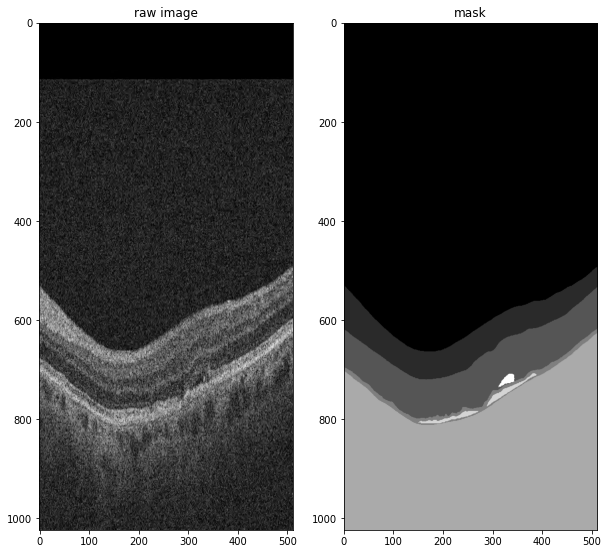

In [ ]:
m=os.listdir(train_img_path)
i = np.random.randint(0,len(m))
print('Image id:', i ,  m[i])
print()
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('raw image')
#raw = load_img(input_train_paths[i])
raw = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))
plt.imshow(raw)
plt.subplot(1, 2, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
plt.imshow(mask)

plt.show()

In [ ]:
class OCT(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return len(self.target_train_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            x[j] = img/.255
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            y[j] = img
        return x, y

        

In [ ]:
import random

# Split our train paths into a training and a validation set
val_samples = 200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OCT(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OCT(batch_size, img_size, val_input_img_paths, val_target_img_paths)

**LOSS**

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +
                                           smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg +
                                  (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)



**MODELS**

**load model and weights**

In [ ]:
#### in case of transfer learning - loading model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
os.chdir('/content/')
model.load_weights("model.h5")

**standard U-net**
*   with BN




In [ ]:
def get_unet():
   
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu',  padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu',  padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu',  padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu',  padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu',  padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu',  padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu',  padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu',  padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu',  padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu',   padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu',  padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu',  padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)

    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(conv9)
    
    # Define the model
    model = keras.Model(inputs, outputs)
   
       
    return model

    
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_unet()
#model.summary()

**U-net-like** 
 

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    #model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
    

    
    return model
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
#model.summary()

**U-net++**

*   Adam better than AdaBound
*   Dropout = 0.5 -> doesn't work




In [ ]:
dropout_rate = 0.0001
bn_axis = 3

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = "relu"

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', padding='same')(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', padding='same')(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x


def Nest_Net(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]
    act = "relu"

    img_input = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='softmax', name='output_1', padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='softmax', name='output_2', padding='same')(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='softmax', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='softmax', name='output_4', padding='same')(conv1_5)

    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=img_input, outputs=[nestnet_output_4])

    return model
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = Nest_Net(IMG_HEIGHT, IMG_WIDTH, color_type=1, num_class=8, deep_supervision=False)
#model.summary()

In [ ]:
### prikaz modela
#tf.keras.utils.plot_model(model, show_shapes=True)

**TRAINING**


*   optmizer - AdaBound




In [ ]:
pip install keras-adabound

In [ ]:
from keras_adabound import AdaBound
opt=AdaBound(lr=1e-3, final_lr=0.1)

In [ ]:
#rmsprop
#opt=Adam(lr=1e-5)
#opt=Adagrad
#opt = tf.keras.optimizers.SGD(learning_rate=0.1)

In [ ]:

model.compile(optimizer=opt, loss="sparse_categorical_crossentropy")
#model.compile(optimizer=opt, loss=tversky_loss)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("OCT_segmentation.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]
# Train the model, doing validation at the end of each epoch.
epochs = 50
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
182/182 [==============================] - 92s 504ms/step - loss: 0.0360 - val_loss: 0.0787
Epoch 2/50
182/182 [==============================] - 93s 509ms/step - loss: 0.0397 - val_loss: 0.0435
Epoch 3/50
182/182 [==============================] - 93s 510ms/step - loss: 0.0368 - val_loss: 0.0585
Epoch 4/50
182/182 [==============================] - 93s 510ms/step - loss: 0.0371 - val_loss: 0.0535
Epoch 5/50
182/182 [==============================] - 93s 510ms/step - loss: 0.0456 - val_loss: 0.0408
Epoch 6/50
182/182 [==============================] - 93s 510ms/step - loss: 0.0335 - val_loss: 0.0424
Epoch 7/50
182/182 [==============================] - 93s 510ms/step - loss: 0.0324 - val_loss: 0.0406
Epoch 8/50
182/182 [==============================] - 93s 511ms/step - loss: 0.0321 - val_loss: 0.0398
Epoch 9/50
182/182 [==============================] - 93s 510ms/step - loss: 0.0320 - val_loss: 0.0415
Epoch 10/50
182/182 [==============================] - 93s 510ms/step - l

In [ ]:
# saving model for later use
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

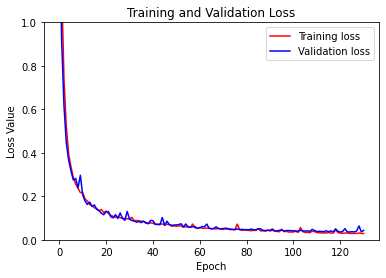

In [ ]:
# Plotting loss and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(131)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

**Getting predictions**

In [ ]:
input_img_paths = sorted(
    [
        os.path.join(val_img_path, fname)
        for fname in os.listdir(val_img_path)
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(val_mask_path, fname)
        for fname in os.listdir(val_mask_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of testing samples:", len(input_img_paths))

Number of testing samples: 185


In [ ]:
test_gen = OCT(batch_size, img_size, input_img_paths, target_img_paths)
test_preds = model.predict(test_gen)

In [ ]:
print(np.shape(test_preds))

(184, 512, 256, 8)


**Visualazing predictions**

Image id: 50
Image id: 50 patient1_raw0057.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


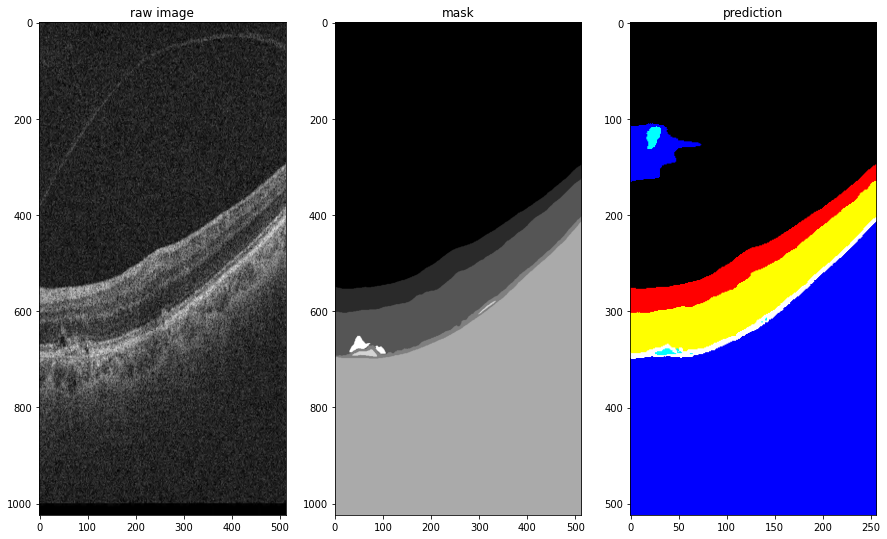

In [ ]:
m=os.listdir(val_img_path)
i = np.random.randint(0,len(input_img_paths))
#i=119 #0, 133, 119
print('Image id:', i )
print('Image id:', i ,  m[i])
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('raw image')
raw = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))
plt.imshow(raw)
plt.subplot(1, 3, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.title('prediction')
pred = np.argmax(test_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)
pred = num_to_colors(pred, IMG_HEIGHT, IMG_WIDTH)
#pred = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred))
plt.imshow(pred)


plt.show()

**Confusion matrix**

In [ ]:
i= 0

mask = load_img(target_img_paths[i], target_size = img_size, color_mode="grayscale")
mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))

pred = np.argmax(test_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)

pred_vector=pred.flatten()
mask_vector=mask.flatten()

### STAVLJENO SAMO DO 150 JER INAČE RAM ODE K VRAGU!!!!
# i range from 1 to number of images in val (test) set
for i in range(1, 184):
  mask = load_img(target_img_paths[i], target_size = img_size, color_mode="grayscale")
  mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))    
  mask_vector = np.concatenate((mask_vector, mask.flatten()), axis=0)
  pred = np.argmax(test_preds[i], axis=-1)
  pred = np.expand_dims(pred, axis=-1)
  pred_vector = np.concatenate((pred_vector, pred.flatten()), axis=0)

1. sklearn

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(mask_vector, pred_vector)

In [ ]:
print(cf_matrix)

[[ 9341677    10520       31        0    32587     1279     5571      157]
 [    7572  1063021    14145        1        0       32     5181      819]
 [      15    60804  1846112    12982        0      763    35967    10369]
 [       0        0    14697   194618    19528    26280     4800        0]
 [       0        0       26    32192 10647530    82812        6        0]
 [       0        0      771    34023    25080   196998     7119        0]
 [       0        0   181119    12827        0     8990   173067     4116]
 [       0        3      353        0        0        0      103      585]]


In [ ]:
cf_matrix_normal = cf_matrix.astype('float32') / cf_matrix.sum(axis=1)[:, np.newaxis]
print(cf_matrix_normal )

[[9.94660780e-01 1.12012344e-03 3.30074399e-06 0.00000000e+00
  3.46972078e-03 1.36182308e-04 5.93175637e-04 1.67166712e-05]
 [6.94187873e-03 9.74559280e-01 1.29678915e-02 9.16782716e-07
  0.00000000e+00 2.93370469e-05 4.74985125e-03 7.50845044e-04]
 [7.62577961e-06 3.09118602e-02 9.38536216e-01 6.59985806e-03
  0.00000000e+00 3.87897989e-04 1.82850943e-02 5.27144725e-03]
 [0.00000000e+00 0.00000000e+00 5.65436687e-02 7.48752515e-01
  7.51299423e-02 1.01106866e-01 1.84670075e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.41578077e-06 2.99110825e-03
  9.89311471e-01 7.69444759e-03 5.57487870e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.92055411e-03 1.28879394e-01
  9.50032387e-02 7.46229985e-01 2.69668284e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.76479734e-01 3.37446957e-02
  0.00000000e+00 2.36504884e-02 4.55296894e-01 1.08281880e-02]
 [0.00000000e+00 2.87356322e-03 3.38122605e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.86590038e-02 5.60344828e-01]]

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

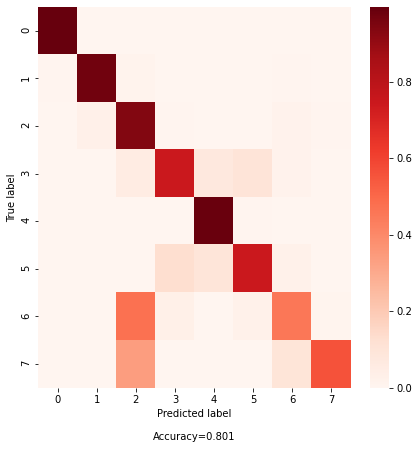

In [ ]:
make_confusion_matrix(cf_matrix_normal, count = False, percent = False, figsize=(7,7), cbar=True, cmap='Reds')

In [ ]:
cf_matrix_normal = (cm1+cm2+cm3+cm4+cm5+cm6)/6

2. pycm

In [ ]:
!pip install pycm

     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 573kB 27.2MB/s 


In [ ]:
import pycm
from pycm import *

In [ ]:
cm = ConfusionMatrix(actual_vector=mask_vector, predict_vector=pred_vector)
cm.classes

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
print(cm)

Predict       0             1             2             3             4             5             6             7             
Actual
0             4811120       11762         70            0             0             0             1             0             

1             2984          768131        8533          0             0             0             0             1             

2             9             52954         1165429       23929         116           1060          16448         143           

3             0             0             10579         100146        31428         21653         3471          4             

4             20776         0             3             7236          7664215       9414          12            0             

5             0             0             552           9446          122544        111786        33002         229           

6             0             0             27272         9720          2502          66403         

**Dice score and std**

In [ ]:
for j in range (0, 8):
  dice = np.zeros((180,1))
  for i in range(0, 180):
    mask = load_img(target_val_paths[i], target_size = img_size, color_mode="grayscale")
    mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))    
    mask_vector=mask.flatten()
    pred = np.argmax(val_preds[i], axis=-1)
    pred = np.expand_dims(pred, axis=-1)
    pred_vector=pred.flatten()
    dice[i] = f1_score(mask_vector, pred_vector, labels=[j], average=None, zero_division=1)
  print(j, "klasa:", np.mean(dice), np.std(dice))